# Single TME analysis with Xenium data

## 1. Loading library

In [1]:
# import library
import skny as sk
import scanpy as sc
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
import pandas as pd
import cv2

import warnings
warnings.filterwarnings("ignore")

Please run the tutorial of "Annotation of tumor contours and distances using Xenium data."

## 2. Reading preprocessed Xenium data

Load the saved data and convert it to the appropriate format.

In [2]:
# load preprocessed object
grid = sc.read_h5ad('example_preprocessed.h5ad')
# load table of distance
df_shotest = pd.read_table("example_distance.txt", index_col=0)
# convert str to pd.interval
df_shotest["region"] = pd.cut(
    df_shotest.dropna()["euclidean"], 
    bins=list(range(-15, 16, 3))
)
# attribute the table to object
grid.shortest = df_shotest

In [3]:
# extract nrow and ncol
N_ROW = len(grid.uns["grid_yedges"]) - 1
N_COL = len(grid.uns["grid_xedges"]) - 1

## 3. Converting from grid data to single TME data

The contoured tumor is divided into contiguous regions, thereby dividing the gene expression data into tumor solid.

In [4]:
# Aggregate gene expression in the interval (-∞, 0] for each tumor solid
# Define new object "solid"
solid = sk.pp.convert_indivisual_solid(grid)

In [5]:
# The number of tumor solid
len(solid.obs)

426

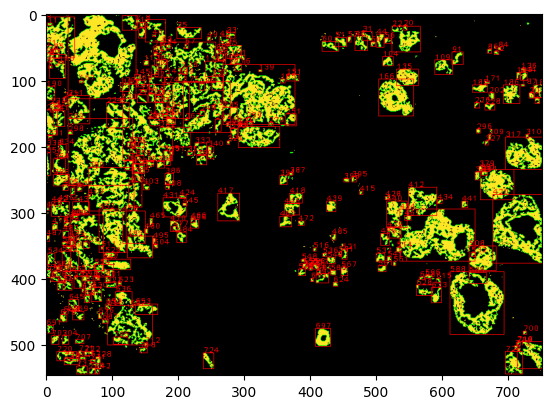

In [6]:
# plot tumor solids
plt.imshow(
    cv2.cvtColor(solid.uns["indivisual_tumor_solid"], cv2.COLOR_BGR2RGB)
)

## 4. Clustering

Using the scanpy function, clustering of tumor solids is performed.

In [7]:
# Filter genes and cells with at least 10 counts
solid.layers["counts"] = solid.X.copy()

# solid object has mean count of expression data of each tumor solid, we can consider it as density.
# The area of tumor solids are defferent each other, so normalize total underestimate gene expression of tumor solid which has large area.
# For the above policy, we recommend not to apply normalize total.
# sc.pp.normalize_total(solid)

# count data is exp distribution
sc.pp.log1p(solid)

# Keep raw data
solid.raw = solid

# reduction of dimension
sc.pp.pca(solid, n_comps=50)

# clustering
sc.pp.neighbors(solid, n_neighbors=20)
sc.tl.umap(solid)
sc.tl.leiden(solid)

2024-02-13 20:37:04.082387: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


## 5. Marker gene analysis

Using the scanpy function, display the top 5 differentially expressed genes for each cluster.

In [8]:
# find defferential expression gene of each cluster
sc.tl.rank_genes_groups(solid, 'leiden', method='wilcoxon')

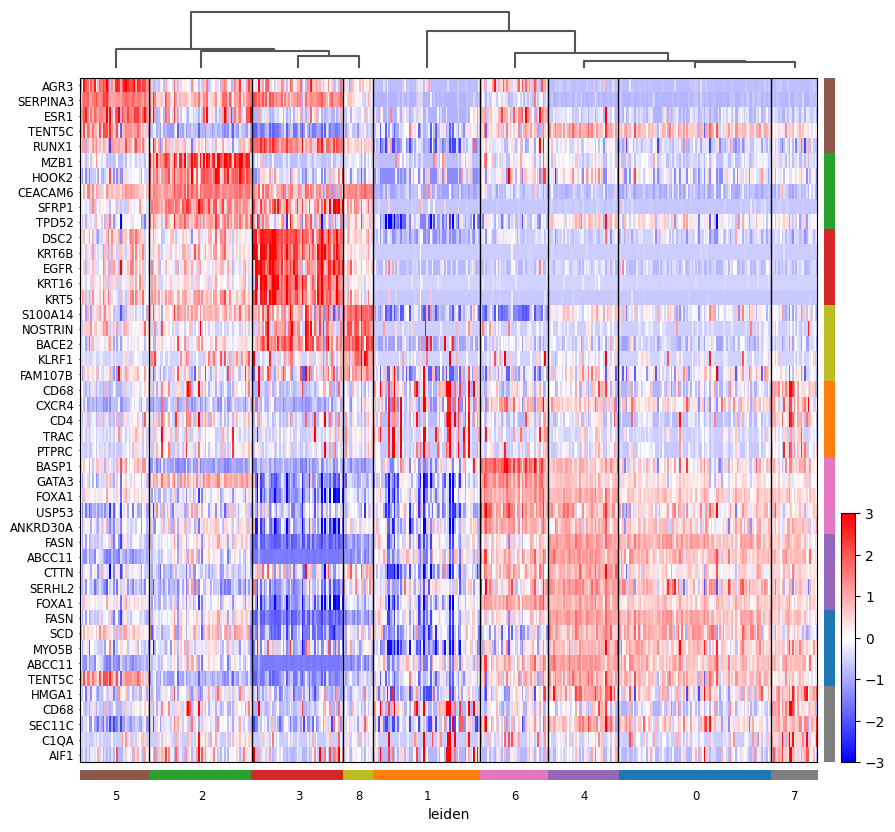

In [9]:
# scale the data
sc.pp.scale(solid, max_value=10)

# heatmap indicate top five gene each cluster
sc.pl.rank_genes_groups_heatmap(
    solid, n_genes=5, use_raw=False, swap_axes=True, vmin=-3, vmax=3, cmap='bwr', 
    figsize=(10,10), save="solid_leiden_deg.png"
)

For tumor solid annotation, we create a dot plot of several genes involved in subtypes and breast cancer progression.

categories: 0, 1, 2, etc.
var_group_labels: Subtypes, Myoepithelial, Invasion, etc.


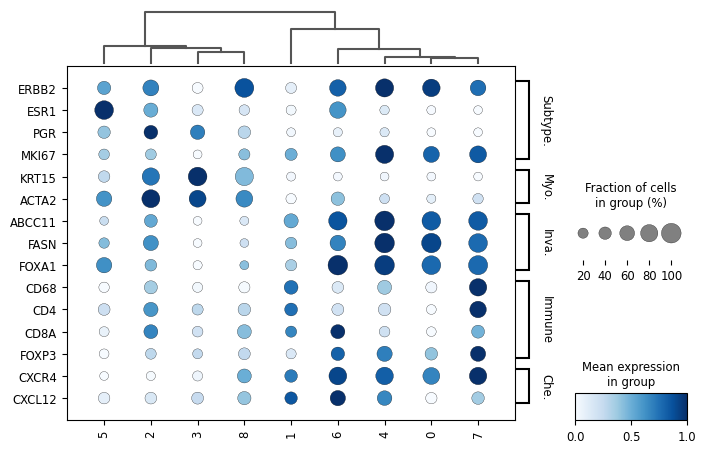

In [10]:
# gene marker dotplot
marker_genes_dict = {
    'Subtypes': ['ERBB2', 'ESR1', 'PGR', 'MKI67'], 
    'Myoepithelial': ['KRT15', 'ACTA2'],
    "Invasion": ["ABCC11", "FASN", "FOXA1", ], 
    "Immune": ["CD68", "CD4", "CD8A", "FOXP3"], 
    "Chemokine": ["CXCR4", "CXCL12",]
}

ax = sc.pl.dotplot(solid, marker_genes_dict, groupby='leiden', dendrogram=True, swap_axes=True,
                   standard_scale='var', smallest_dot=40, color_map='Blues', figsize=(8,5), 
                   save="solid_clustering_marker.png")

## 6. UMAP

Using the scanpy function, the UMAP is created.

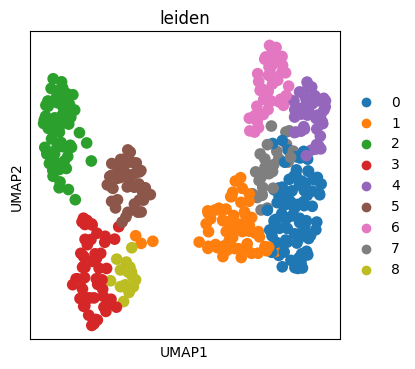

In [11]:
# plot
fig, ax = plt.subplots(figsize=(4, 4))

sc.pl.umap(
    solid,
    color=[
        "leiden",
    ],
    ax=ax,
    palette=sc.pl.palettes.vega_10, 
    save="solid_umap.png"
)


## 7. Mapping cluster label to image

Maps the clustering generated by the leiden algorithm onto the original space.

In [12]:
# convert leiden label to image data
df_shotest = solid.shortest.copy()
df_solid = solid.obs.copy()

# convert int data to apply imshow
df_solid["leiden"] = df_solid["leiden"].astype(int)
df_shotest = pd.merge(df_shotest, df_solid, on="solid", how="left")

In [13]:
# match color to scanpy
gscmap=ListedColormap(
    sc.pl.palettes.vega_10[:len(solid.obs["leiden"].unique())]
)
gscmap.set_under(color='black') 
gscmap.set_bad(color='black') 

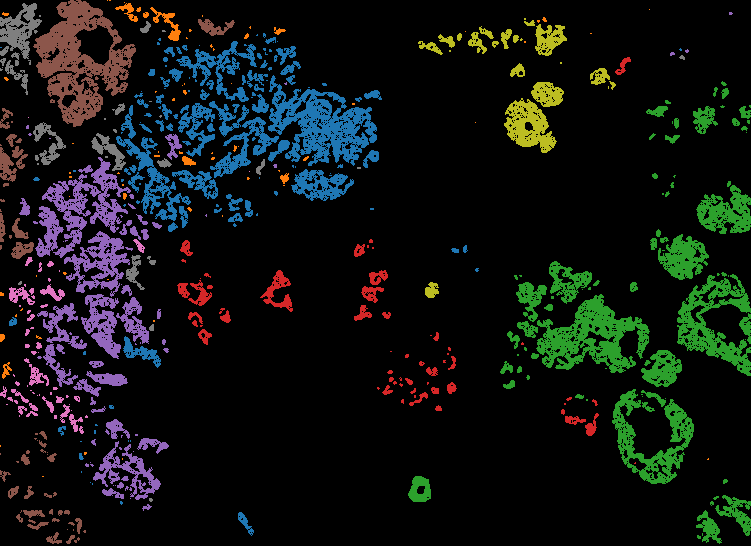

In [14]:
# save figure
fig, ax = plt.subplots(figsize=(N_COL, N_ROW), dpi=1, tight_layout=True)

image = np.array(df_shotest["leiden"].astype(float).fillna(-1)).reshape(N_ROW, N_COL)

ax.imshow(
    image, cmap=gscmap,
    vmin=0,
    vmax=len(solid.obs["leiden"].unique())-1,
)
ax.axis('off')

plt.savefig("figures/spatial_solid_leiden.png", dpi=1)

In [ ]:
# If you want to create a label based on annotation, execute the following code.
#solid.obs['leiden_anno'] = solid.obs['leiden'].copy()

# anntation
#solid.obs['leiden_anno'] = solid.obs['leiden_anno'].replace({
#    '0': 'IDC #1', 
#    '1': 'DCIS to IDC', 
#    '2': "DCIS #1", 
#    '3': "ADH to DCIS",
#    '4': "IDC #2",
#    '5': "DCIS #2",
#    '6': "IDC #3",
#    '7': "IDC #4",
#    '8': "DCIS #3", }
#)

## 8. Trajectory analysis

Tumor solid trajectory analysis using the PAGA algorithm.

In [17]:
# setting for figure
sc.settings.set_figure_params(dpi=80, frameon=True, figsize=(3, 3), facecolor="white")

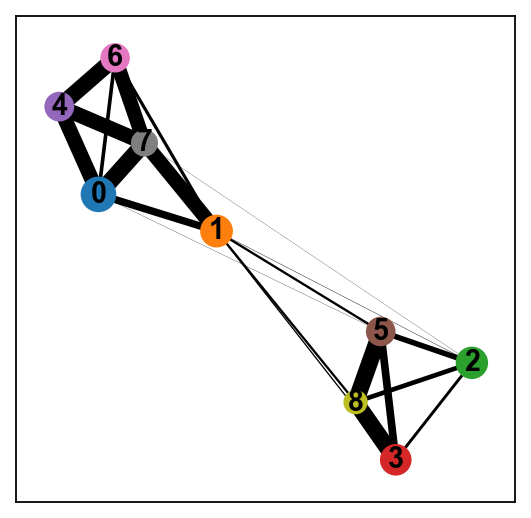

In [18]:
# generate graph structure based on simmilarity of gene expresssion of each cluster
# Uging PAGA algorithm
sc.tl.paga(solid, groups='leiden')

fig, ax = plt.subplots(figsize=(4, 4))
sc.pl.paga(
    solid, color=['leiden', ], ax=ax, #legend_fontoutline=2,
    save="solid_leiden.png"
)

In [19]:
# place tumor solids onto paga space
sc.tl.draw_graph(solid, init_pos='paga')

# calculate preudotime which root is 3
solid.uns['iroot'] = np.flatnonzero(solid.obs['leiden']  == '3')[0]
sc.tl.dpt(solid)

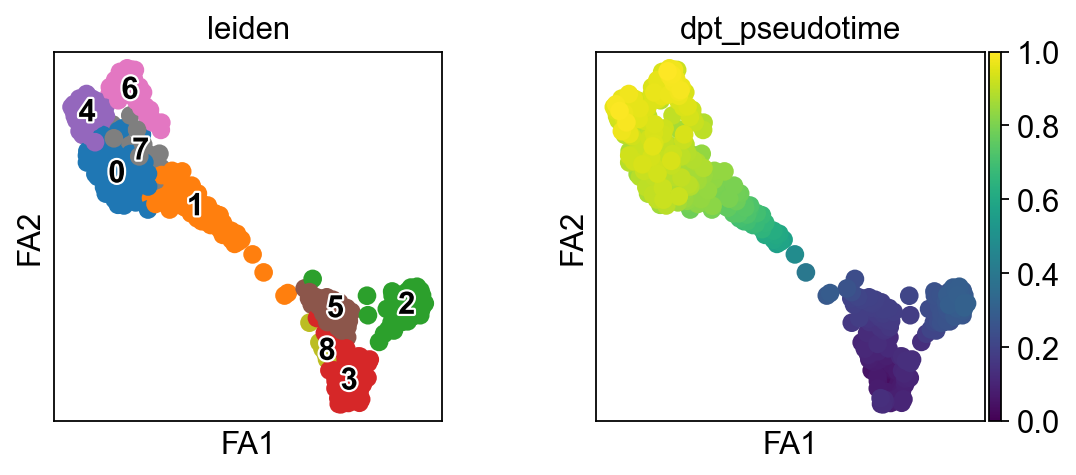

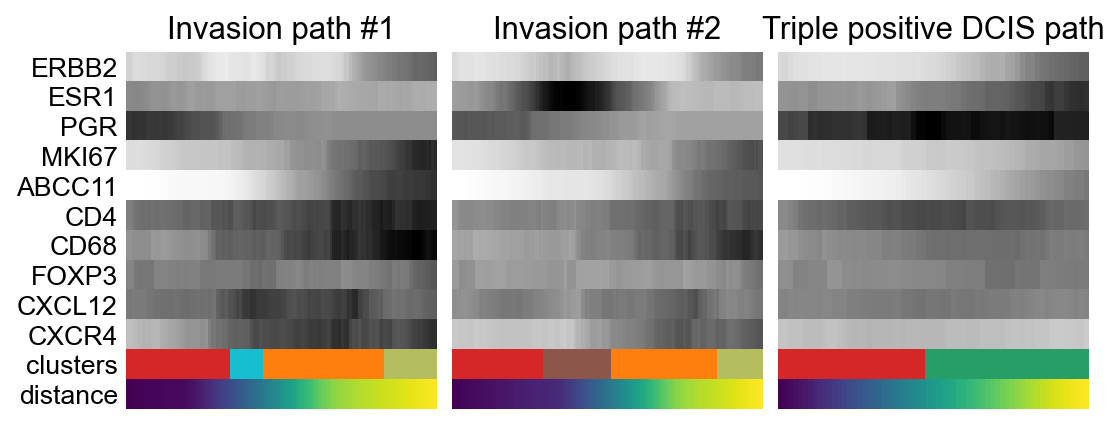

In [20]:
# Correlation batween gene expression and preudotime
# See https://scanpy-tutorials.readthedocs.io/en/latest/paga-paul15.html

# set the root cluster 3
#solid.uns['iroot'] = np.flatnonzero(solid.obs['leiden']  == '3')[0]

# gene list
gene_names = [
    "ERBB2", "ESR1", "PGR",               # subtype
    "MKI67", "ABCC11", #"FASN", "FOXA1",  # invasion
    "CD4", "CD68", "FOXP3",               # immune cells
    "CXCL12", "CXCR4",                    # Chemokines
]     

# plot cluter and pseudotime onto PAGA space
sc.pl.draw_graph(
    solid, color=['leiden', 'dpt_pseudotime'], legend_loc='on data', 
    save="solid_leiden_pseudotime.png", legend_fontoutline=2, 
)

# define three pathway of tumor progression
paths = [
    ('Invasion path #1', ["3", "8", "1", "7", ]),
    ('Invasion path #2', ["3", "5", "1", "7", ]), 
    ('Triple positive DCIS path', ["3", "2", ]), 
]

solid.obs['distance'] = solid.obs['dpt_pseudotime']
solid.obs['clusters'] = solid.obs['leiden']  # just a cosmetic change

# scale
sc.pp.scale(solid, max_value=10)

# plot heatmap
_, axs = plt.subplots(ncols=3, figsize=(7, 3), gridspec_kw={'wspace': 0.05, 'left': 0.12})
plt.subplots_adjust(left=0.05, right=0.98, top=0.82, bottom=0.2)
for ipath, (descr, path) in enumerate(paths):
    _, data = sc.pl.paga_path(
        solid, path, gene_names,
        show_node_names=False,
        ax=axs[ipath],
        ytick_fontsize=12,
        left_margin=0.15,
        n_avg=50,
        annotations=['distance'],
        show_yticks=True if ipath==0 else False,
        show_colorbar=False,
        color_map='Greys',
        groups_key='clusters',
        color_maps_annotations={'distance': 'viridis'},
        title='{}'.format(descr),
        return_data=True,
        show=False)

plt.savefig('figures/pseudo_solid_cluster.png', dpi=500)
plt.show()

Pseudotime correlates with ERBB2, MKI67, and ABCC1, indicating that it reflects cancer progression with high quality.

In addition, macrophage infiltration and high expression of CXCL12 and CXCR4 were observed in the bottleneck area during the transition from DCIS to IDC (cluster 1).

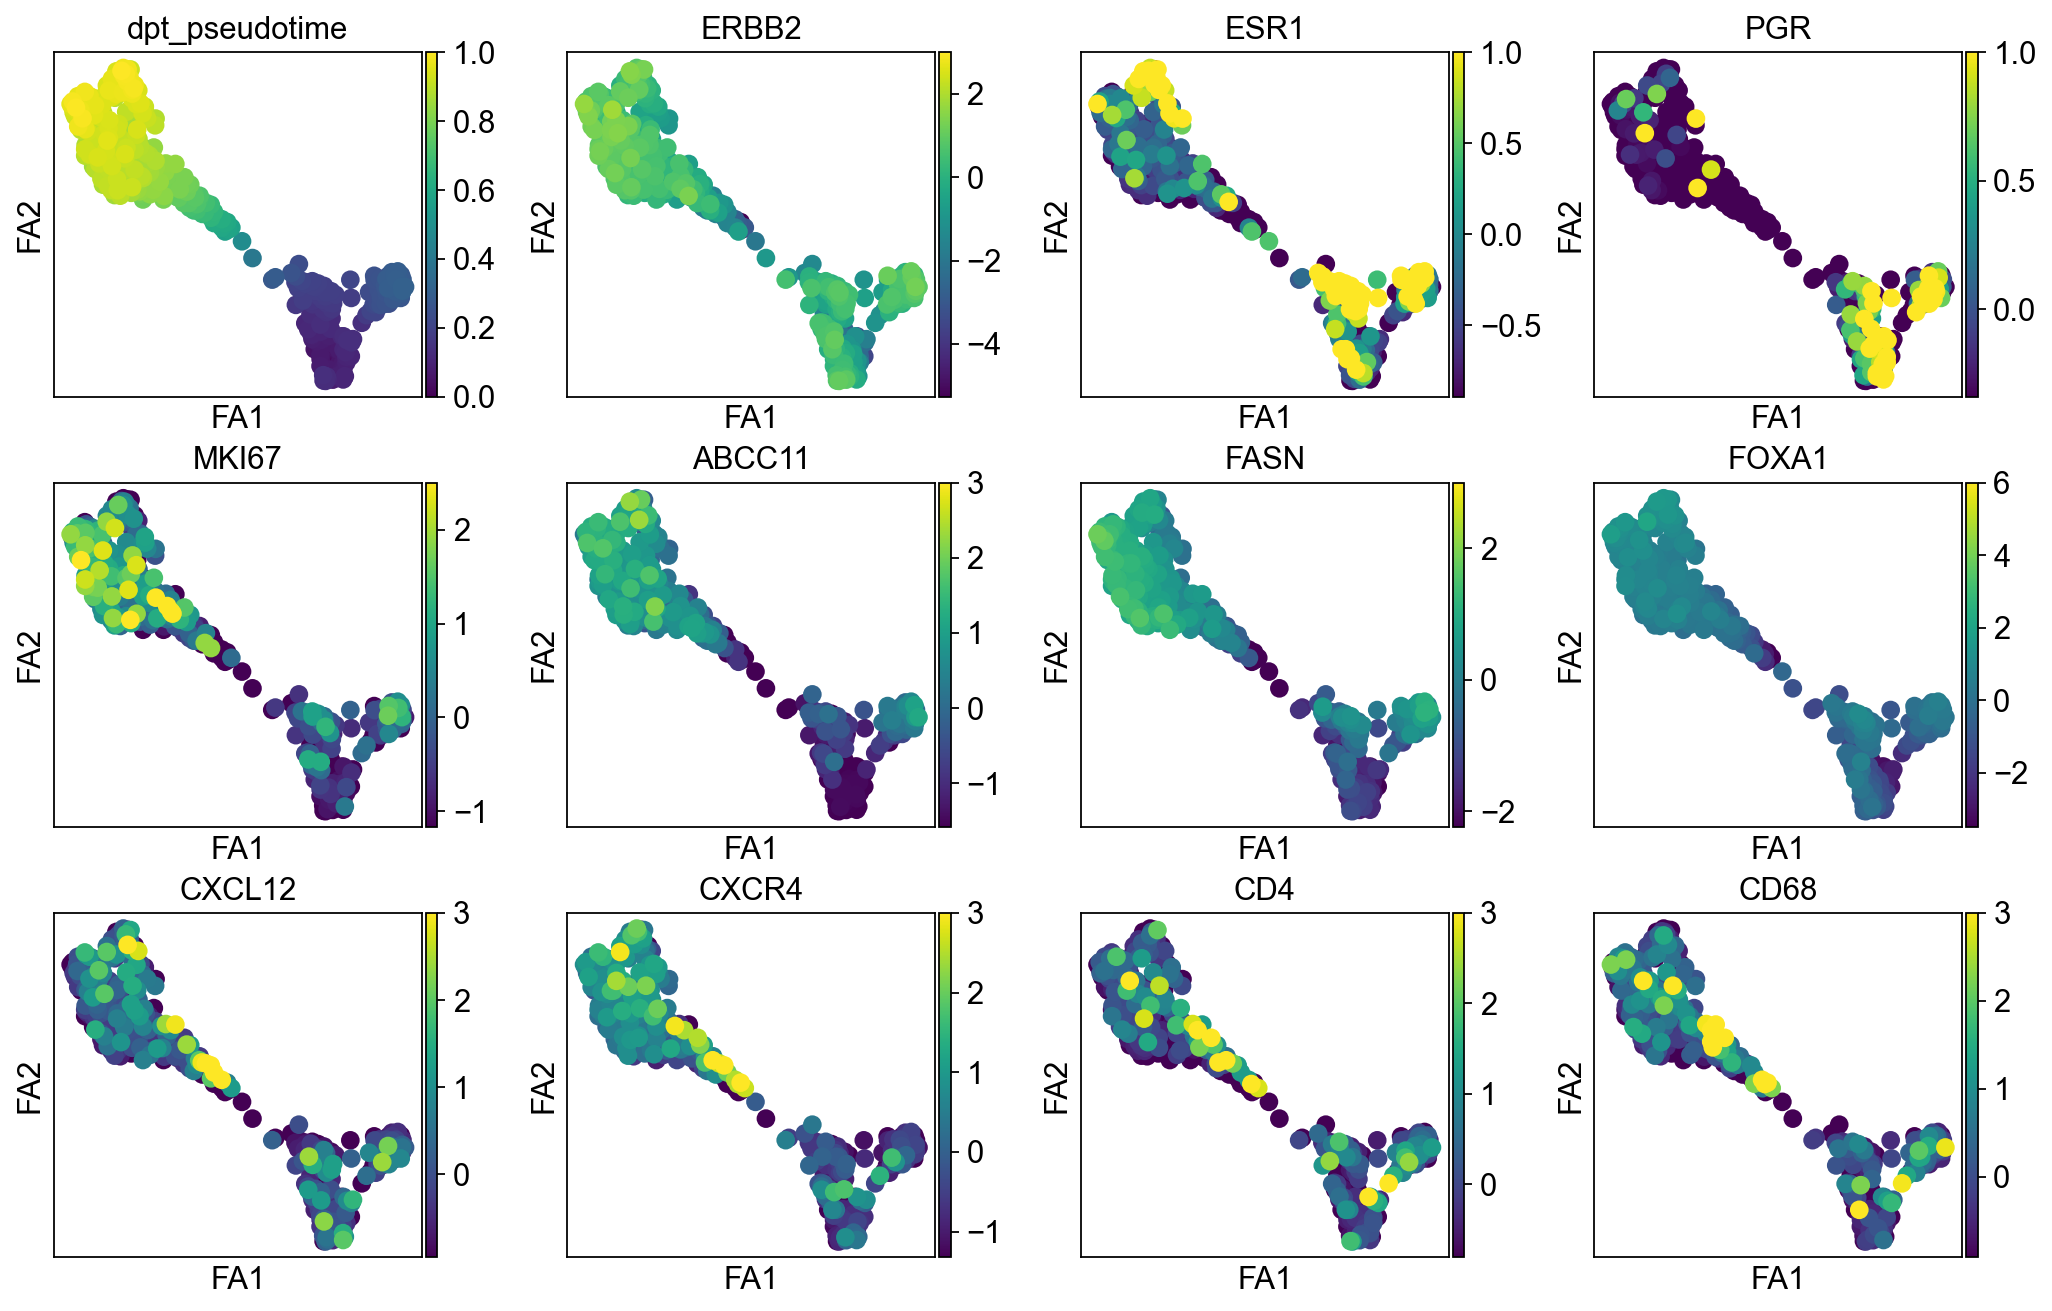

In [21]:
# each gene plot
sc.pl.draw_graph(
    solid, 
    color=['dpt_pseudotime', 
           "ERBB2", "ESR1", "PGR", 
           "MKI67", "ABCC11", "FASN", "FOXA1", 
           "CXCL12", "CXCR4", "CD4", "CD68"], 
    vmax=[1, 
          3, 1, 1, 
          2.5, 3, 3, 6, 
          3, 3, 3, 3],
    use_raw=True, sort_order=True, 
    save="solid_gene.png"
)